WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode finished after 199 time steps


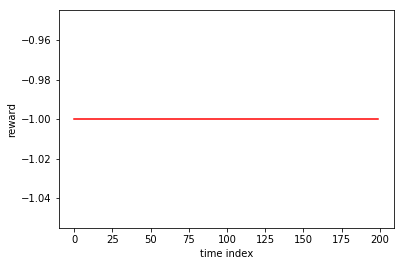

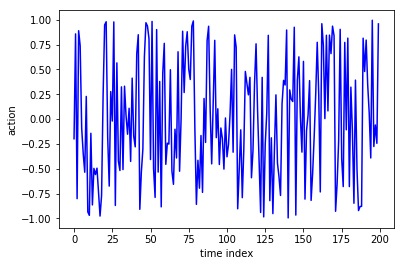

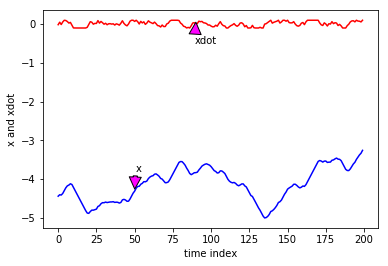

In [3]:
"""
optimal control problem: park a car in minimum time,
objective: control car such that car rests at origin finally with any initial position and velocity
system dynamic model: x_dot_dot = u, where x is position and u is control input
car can take any u in interval [-1, 1] (u is a continuous variable
reward is 0  at x=0 and xdot =0
reward is -1 otherwise
(I may modify reward later)
"""

import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt


class Car(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 30
    }

    dt = 0.75
    min_acceleration = -1.0
    max_acceleration = +1.0
    max_speed = 0.1
    min_position = -5
    max_position = 0.5
    goal_position = 0.0
    acceleration_mag = 0.1

    def __init__(self):
        self.low_state = np.array([self.min_position, -self.max_speed])
        self.high_state = np.array([self.max_position, self.max_speed])
        self.viewer = None
        self.action_space = spaces.Box(low=self.min_acceleration, high=self.max_acceleration, shape=(1,))
        self.state_space = spaces.Box(low=self.low_state, high=self.high_state)
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, a):
        position = self.state[0]
        velocity = self.state[1]
        acceleration = min(max(a[0], -1.0), 1.0)

        velocity = velocity + self.dt * acceleration * self.acceleration_mag
        if velocity > self.max_speed:
            velocity = self.max_speed
        if velocity < -self.max_speed:
            velocity = -self.max_speed

        position = position + self.dt * velocity
        if position > self.max_position:
            position = self.max_position
        if position < self.min_position:
            position = self.min_position
        if position == self.min_position and velocity < 0:
            velocity = 0

        done = bool(abs(position - self.goal_position) < 0.05 and 0 < velocity < 0.01 and acceleration < 0)

        if done:
            reward = 0
        else:
            reward = -1

        self.state = np.array([position, velocity])
        return self.state, reward, done, {}

    def reset(self):
        self.state = np.array([self.np_random.uniform(low=self.min_position+0.5, high=self.min_position+1), 0])
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.max_position - self.min_position
        scale = screen_width/world_width
        carwidth=30
        carheight=15

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            line_s_x = -2
            line_s_y = 0
            line_e_x = 2
            line_e_y = 0
            line = self.viewer.draw_line((line_s_x, line_s_y), (line_e_x, line_e_y))
            self.viewer.add_geom(line)

            clearance = 10

            left, right, top, bottom = -carwidth/2, carwidth/2, carheight, 0
            car = rendering.FilledPolygon([(left, bottom), (left, top), (right, top), (right, bottom)])
            car.add_attr(rendering.Transform(translation=(0, clearance)))
            car.set_color(1, .5, .5)
            self.cartrans = rendering.Transform()
            car.add_attr(self.cartrans)
            self.viewer.add_geom(car)

            wheel1 = rendering.make_circle(carheight/2.5)
            wheel1.set_color(0.5, 0.5, 0.5)
            wheel1.add_attr(rendering.Transform(translation=(carwidth/4,clearance)))
            wheel1.add_attr(self.cartrans)
            self.viewer.add_geom(wheel1)
            wheel2 = rendering.make_circle(carheight/2.5)
            wheel2.add_attr(rendering.Transform(translation=(-carwidth/4, clearance)))
            wheel2.add_attr(self.cartrans)
            wheel2.set_color(0.5, 0.5, 0.5)
            self.viewer.add_geom(wheel2)
            parkx = (self.goal_position-self.min_position)*scale
            parky1 = 0
            parky2 = parky1 + 50
            park = rendering.Line((parkx, parky1), (parkx, parky2))
            park.set_color(0.8, 0.8, 0.8)
            self.viewer.add_geom(park)

        pos = self.state[0]
        self.cartrans.set_translation((pos-self.min_position)*scale, 0)

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')


env = Car()
iteration_num = 1
index = 200
for i_episode in range(iteration_num):
    observation = env.reset()
    reward_vector = np.zeros(index)
    x = np.zeros(index)
    xdot = np.zeros(index)
    action_vector = np.zeros(index)
    T = np.zeros(index)
    for t in range(index):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        reward_vector[t] = reward
        action_vector[t] = action
        x[t] = observation[0]
        xdot[t] = observation[1]
        T[t] = t
        if done or t == index - 1:
            env.close()
            print("Episode finished after", t, "time steps")


plt.plot(T, reward_vector, 'r')
plt.ylabel('reward')
plt.xlabel('time index')
plt.show()

plt.plot(T, action_vector, 'b')
plt.ylabel('action')
plt.xlabel('time index')
plt.show()

plt.plot(T, x, 'b')
plt.plot(T, xdot, 'r')
plt.annotate('x', xy=(T[50] + 0.05, x[50] + 0.05), xytext=(T[50] + 0.5, x[50] + 0.5), arrowprops=dict(facecolor='magenta', shrink=0.01), )
plt.annotate('xdot', xy=(T[90] + 0.05, xdot[90] + 0.05), xytext=(T[90] - 0.5, xdot[90] - 0.5), arrowprops=dict(facecolor='magenta', shrink=0.01), )
plt.ylabel('x and xdot')
plt.xlabel('time index')
plt.show()
